In [85]:
## Run when initialise the code
import os

import geopandas as gpd
import osmnx as ox
from geopandas import GeoDataFrame, GeoSeries
from osmnx import io
import glob

project_crs = 'epsg:3857'
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point, LineString, MultiPolygon, MultiPoint
import math
import warnings
import pandas as pd
import shutil
from tqdm import tqdm
import time
warnings.filterwarnings(action='ignore')
from momepy import remove_false_nodes,extend_lines
pjr_loc = os.path.dirname(os.getcwd())



<span style="color: Green;font-size: 30px">Module 1:Preliminary work</span>
<ul> <li>Download data from OpenStreetMap, project it, and convert it to a GeoDataFrame. OSMnx automatically resolves topology errors and retrieves only the street-related polylines.</li>
 <li>Identify roundabout elements, if any exist, and store them in a separate DataFrame.</li>
  <li>Remove additional irrelevant line objects based on values of the OSM 'tunnel' and 'highway' keys.</li>
   <li>Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.</li>
   </ul>


<span style="color: Red;font-size: 30px">Module 2 -3:Detect  parallel streets segments and merge them </span>
<ul> <li>For each group of streets with the same name search for parallel segments</li>
 <li> Use DBSCAN to classify streets based on their angle, and group each class. Outliers could not consider parallel with any street, thus removed</li>
  <li>The parallel test is on street segments that  have the same name and belong to the same angle group.
    <ul><li>Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.</li></ul>
    </li>

   </ul>

In [76]:
## Run when initialise the code
# In this example, the data is extracted from OSM by specifying a location's name, but you can also download data using a specified polygon. The code is designed to handle multiple polygons or location names seamlessly.

# Download data from OpenStreetMap, project it, and convert it to a GeoDataFrame. OSMnx automatically resolves topology errors and retrieves only the street-related polylines.

place = 'Turin'
print(place)
data_folder  = f'places/{place.replace(",","_").replace(" ","_")}_test'
os.makedirs(f'{data_folder}/delete_2_nodes',exist_ok = True)
os.makedirs(f'{data_folder}/split_tp_intersection',exist_ok = True)

Turin


In [77]:
data_folder

'places/Turin_test'

In [84]:
graph = ox.graph_from_place(place, network_type='all')
graph = ox.bearing.add_edge_bearings(graph, precision=1)
graph_pro = ox.projection.project_graph(graph, to_crs=project_crs)
io.save_graph_geopackage(graph_pro, filepath=f'{data_folder}/osm_data.gpkg', encoding='utf-8', directed=False)


In [78]:
## Run when initialise the code
# find and store roundabout
my_gdf = gpd.read_file(f'{data_folder}/osm_data.gpkg',layer = 'edges')# Identify roundabout elements, if any exist, and store them in a separate DataFrame.
is_junction= True if 'junction' in my_gdf.columns else False
if is_junction:
    round_about = my_gdf[my_gdf['junction'].isin(['roundabout', 'circular'])]
    my_gdf= my_gdf[~((my_gdf['junction'] == 'roundabout') | (my_gdf['junction'] == 'circular'))]

In [79]:

# Remove additional irrelevant line objects based on values of the OSM 'tunnel' and 'highway' keys.
if 'tunnel' in my_gdf.columns:
    my_gdf = my_gdf[~((my_gdf['tunnel'] == 'building_passage') | (my_gdf['tunnel'] == 'yes'))]
to_remove = my_gdf[~((my_gdf['highway'] == 'motorway') | (my_gdf['highway'] == 'trunk')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'trunk_link'))]


# Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.
df_pro = to_remove.to_crs(project_crs).dropna(subset=['name'])
df_pro = df_pro[df_pro['name']!='']
df_pro['angle'] = df_pro['bearing'].apply(lambda x: x if x < 180 else x - 180)
df_pro['length'] = df_pro.length

In [80]:
df_pro

,u,v,key,osmid,oneway,ref,highway,maxspeed,reversed,length,...,name,lanes,access,bridge,junction,width,service,tunnel,geometry,angle
5,13924308,945268794,0,61293337,True,,tertiary,,False,14.765415,...,Corso Principe Oddone,,,,,,,,"LINESTRING (853760.994 5633752.261, 853762.875...",7.3
6,13924308,1625774856,0,133270821,True,,primary,,False,29.481956,...,Piazza Statuto,2,,,,,,,"LINESTRING (853760.994 5633752.261, 853731.528...",91.9
7,13924308,6711150268,0,125743679,True,,primary,,False,25.112347,...,Corso Principe Eugenio,2,,,,,,,"LINESTRING (853785.084 5633759.355, 853760.994...",73.6
8,13924308,4738859081,0,966240517,True,,primary,,False,14.741098,...,Piazza Statuto,2,,,,,,,"LINESTRING (853760.282 5633737.537, 853760.994...",2.8
9,945268794,4612216359,0,186768349,True,,tertiary,,False,25.535312,...,Corso Principe Oddone,,,,,,,,"LINESTRING (853762.875 5633766.906, 853774.130...",26.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49737,11152626706,11152626738,0,"[555010500, 1020865228]",True,,primary,,False,30.434909,...,Corso Venezia,2,yes,,,,,,"LINESTRING (855579.721 5637034.031, 855572.730...",35.5
49739,11152566893,11152626707,0,1020865229,True,,primary,,False,22.518760,...,Corso Venezia,,,,,,,,"LINESTRING (855594.749 5637018.434, 855608.141...",36.5
49741,11152566901,11152626712,0,1033056948,True,,residential,,False,16.673466,...,Corso Venezia,,,,,,,,"LINESTRING (855596.986 5636992.382, 855601.072...",37.1
49743,11152626709,11152626708,0,"[1203064155, 28105724]",True,,tertiary,,False,13.133241,...,Via Breglio,,,,,,,,"LINESTRING (855558.681 5637036.759, 855551.201...",97.4


In [81]:
# region
# Functions and classes to be utilized - Module 2
def length_of_parallel(my_s_join: GeoDataFrame, the_buffer: GeoSeries, geo_field: str) -> int:
    my_s_join['geometry'] = my_s_join[geo_field]
    new_data_0 = my_s_join.sjoin(GeoDataFrame(geometry=the_buffer, crs=project_crs), how='inner').reset_index()
    if len(new_data_0) == 0:
        return 0
    return len(new_data_0[new_data_0['index'] != new_data_0['index_right']])
def check_parallelism(to_translate: GeoDataFrame) -> bool:
    my_buffer = to_translate['geometry'].buffer(cap_style=2, distance=30, join_style=3)
    to_translate['geometry_right'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'right'))
    to_translate['geometry_left'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'left'))
    if length_of_parallel(to_translate, my_buffer, 'geometry_right') > 10 or length_of_parallel(to_translate, my_buffer, 'geometry_left') > 10:
        return True
    else:
        return False

# Functions and classes to be utilized - Module 3
def update_list(line_local):
    """
    add the first start/end point into the list
    :param line_local:
    :return:
    """
    list_pnts_of_line_group.extend([Point(line_local.coords[0]), Point(line_local.coords[-1])])
def create_center_line(one_poly):
    """
    This method calculate new line between the farthest points of the simplified polygon
    :param one_poly:
    :return:
    """

    pnt_list = one_poly.exterior.coords[:-1]
    list_shp = [Point(item) for item in pnt_list]
    dis, dis_2, dis_3 = 0, 0, 0
    third_dis = (-1, -1)
    # The new line will be determined by the third-farthest points
    for k, point in enumerate(list_shp):
        j = k
        for point2 in list_shp[k + 1:]:
            j += 1
            temp_dis = point.distance(point2)
            if temp_dis > dis:
                dis = point.distance(point2)
            elif temp_dis > dis_2:
                dis_2 = point.distance(point2)
            elif temp_dis > dis_3:
                third_dis = (k, j)
                dis_3 = point.distance(point2)
    max_dist['name'].extend([id_pol + 2, id_pol + 2])
    max_dist['geometry'].extend([list_shp[third_dis[0]], list_shp[third_dis[1]]])
def add_more_pnts_to_new_lines(pnt_f_loc: Point, pnt_l_loc: Point, line_pnts: list) -> list:
    """
    This method checks if more points should be added to the new lines by checking along the new line if the distance to the old network roads are more than 10 meters
    :return:
    """
    # Calculate distance and azimuth between the first and last point
    dist = pnt_f_loc.distance(pnt_l_loc)
    x_0 = pnt_f_loc.coords[0][0]
    y_0 = pnt_f_loc.coords[0][1]
    bearing = math.atan2(pnt_l_loc.coords[0][0] - x_0, pnt_l_loc.coords[0][1] - y_0)
    bearing = bearing + 2 * math.pi if bearing < 0 else bearing
    # Calculate the number of  checks going to carry out
    length_to_check  =50
    loops = int(dist /length_to_check)

    # Calculate  the first point over the line
    for dis_on_line in range(1, loops):
        x_new = x_0 + length_to_check  * dis_on_line * math.sin(bearing)
        y_new = y_0 + length_to_check  * dis_on_line * math.cos(bearing)
        # S_joins to all the network lines (same name and group)
        # if the distance is less than 10 meters continue, else: find the projection point and add it to the correct location and run the function agein
        one_pnt_df = GeoDataFrame(geometry=[Point(x_new, y_new)], crs=project_crs)
        s_join_loc = one_pnt_df.sjoin_nearest(data, distance_col='dis').iloc[0]
        if s_join_loc['dis'] > 10:
            pnt_med = s_join_loc['geometry']
            line = data.loc[s_join_loc['index_right']]['geometry']
            line_pnts.append(line.interpolate(line.project(pnt_med)))
            line_pnts = add_more_pnts_to_new_lines(pnt_med, pnt_l_loc, line_pnts)
            return line_pnts
    return line_pnts
def update_df_with_center_line(new_line,is_simplified=0,group_name= -1):
    """
    update our dictionary with new lines
    :param is_simplified:
    :param new_line:
    :param group_name: According to the DBSCAN algorithm, if no =-1
    :return:
    """
    dic_final['name'].append(name)
    # dic_final['geometry'].append(LineString(coordinates=(pnt_list[max_dis[0]], pnt_list[max_dis[1]])))
    dic_final['geometry'].append(new_line)
    dic_final['highway'].append(data.iloc[0]['highway'])
    dic_final['bearing'].append(data['angle'].mean())
    dic_final['group'].append(group_name)
    dic_final['is_simplified'].append(is_simplified)
# group the street segments by street name
my_groupby = df_pro.groupby('name')
dic_final = {'name': [], 'geometry': [], 'highway': [], 'bearing': [], 'group': [],'is_simplified':[]}

for_time = len(my_groupby)
# endregion

In [82]:
is_test = False
number_of_parallel = 0 # count the number of polylines were refined
with tqdm(total=for_time) as pbar: #  It is used in order to visualise the progress by progress bar
    for i, street in enumerate(my_groupby):
        if is_test:
            name = 'Corso Orbassano','Corso Umbria',"['Corso Venezia', 'Raccordo Autostradale Torino-Caselle'].'monterey, boulevard, the street for example,Corso Achille Mario Dogliotti, Vicolo Valtorta IN THE END"
            res = my_groupby.get_group(name)
        else:
            res = street[1] # it holds all the streets
            name = street[0] # It holds the streets name
                # For each group of streets with the same name search for parallel segments
        pbar.update(1) # for the progress bar
        # Remove segments without angle. If less than two segments being left move to the next group.
        res = res.dropna(subset=['angle'], axis=0)
        if len(res) < 2:
            data = res
            _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
            continue
        # Use DBSCAN to classify streets based on their angle, and group each class. Outliers could not consider parallel with any street, thus removed
        res['group'] = DBSCAN(eps=10, min_samples=2).fit(res['angle'].to_numpy().reshape(-1, 1)).labels_
        # if all is -1, don't touch the element
        if (res['group']== -1).all():
            data = res
            _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
            continue
        # cur_group = res[(res['group'] > -1) | (res.length>20)].groupby('group') # Remove short segments with -1 classification values
        # The parallel test is on street segments that  have the same name and belong to the same angle group.
        for group in res.groupby('group'):
            data = group[1]
            if group[0] ==-1: # No need to check if is parallel
                _  = data['geometry'].apply(lambda x:update_df_with_center_line(x))
                continue
            if check_parallelism(data.copy()):
                number_of_parallel+=len(data) # Update the number of parallel polylines
                # if among of lines with same angles some are parallel:
                # new points DataFrame of start/end line of each group
                list_pnts_of_line_group = []
                data['geometry'].apply(update_list)
                df_pnts = GeoDataFrame(geometry=list_pnts_of_line_group, crs=project_crs).drop_duplicates()

                # unify lines to one polygon
                buffers = data.buffer(cap_style=3, distance=30, join_style=3)
                one_buffer = buffers.unary_union

                max_dist = {'name': [], 'geometry': []}
                # simplify polygon with simplify function. If one_buffer is multipolygon object simplify each one them separately
                if isinstance(one_buffer, MultiPolygon):
                    for id_pol, polygon in enumerate(one_buffer):
                        create_center_line(polygon)
                else:
                    id_pol = -1
                    create_center_line(one_buffer)
                max_df = GeoDataFrame(max_dist, crs=project_crs)
                max_df.to_file(f'{data_folder}/max_df.shp')
                # find for each points the closet point from the oribinal data. the closet points will create the new line
                s_join = max_df.sjoin_nearest(df_pnts).groupby('name')
                for geo in s_join:
                    same_name = geo[1]
                    if same_name.iloc[0]['index_right'] == same_name.iloc[1]['index_right']:
                        continue
                    in_0 = same_name.iloc[0]['index_right']
                    in_1 = same_name.iloc[1]['index_right']
                    # These points will be served to be initial reference in order to find more points
                    pnt_f = df_pnts.loc[in_0]['geometry']
                    pnt_l = df_pnts.loc[in_1]['geometry']
                    lines_pnt_geo = add_more_pnts_to_new_lines(pnt_f, pnt_l, [pnt_f])
                    lines_pnt_geo.append(pnt_l)
                    # Update dic_final
                    update_df_with_center_line(LineString(lines_pnt_geo),1,group[0])

            else:
                _  = data['geometry'].apply(lambda x:update_df_with_center_line(x))
        if is_test:
            break


print(number_of_parallel)

100%|██████████| 2493/2493 [03:52<00:00, 10.70it/s] 

11133


In [89]:
print('create new files')
# remove short lines
final_cols = ['name', 'geometry', 'highway', 'bearing', 'length']
new_network = GeoDataFrame(dic_final, crs=project_crs)

# create network
new_network.to_file(f'{data_folder}/simp.shp')

create new files


In [86]:
# starting point
new_network = gpd.read_file(f'{data_folder}/simp.shp')
new_network

,name,highway,bearing,group,is_simplif,geometry
0,11,path,106.60,-1,0,"LINESTRING (857888.020 5626761.570, 857902.213..."
1,11,path,106.60,-1,0,"LINESTRING (857638.976 5626560.639, 857618.671..."
2,18,path,40.85,-1,0,"LINESTRING (860173.665 5627099.066, 860141.427..."
3,18,path,40.85,-1,0,"LINESTRING (860173.665 5627099.066, 860196.674..."
4,18,path,164.90,-1,0,"LINESTRING (860110.012 5627377.578, 860111.003..."
...,...,...,...,...,...,...
16264,"['Viale Enrico Millo', 'Viale Virgilio']",pedestrian,7.40,-1,0,"LINESTRING (855537.353 5629215.626, 855536.028..."
16265,"['Viale Rombon', ""Viale Stretta D'Auzza""]",path,84.20,-1,0,"LINESTRING (859391.734 5626943.304, 859404.759..."
16266,"['Viale San Gabriele', 'Viale Castelgomberto']",path,30.80,-1,0,"LINESTRING (858361.706 5626215.887, 858343.194..."
16267,"['Viale Stefano Turr', 'Viale Virgilio']",pedestrian,27.10,-1,0,"LINESTRING (855542.740 5629433.523, 855532.020..."


In [87]:
# region
# Classes to be employed during the execution of this code.
#Intersection
#Split in intersection
class Intersection:
    def __init__(self,network:GeoDataFrame,number:int):
        """

        :param network:
        :param number: give a unique name to the files created during the process (this class will be use again in this code)
        """
        self.my_network = network
        self.inter_pnt_dic = {'geometry':[],'name':[]}
        self.lines_to_delete =[]
        self.num = number
    def delete_false_intersection(self,name_to_splt='name'):

        if 'length' in self.my_network.columns: # To run the code smoothly we need to remove 'length' col if exist
            self.my_network.drop(columns='length',inplace= True)
        org_network= self.my_network.copy()
        # It should be executed twice in order to clean all
        for _  in range(2):
            # First clean all the false node
            self.my_network = remove_false_nodes(self.my_network)
            # the previous function has changed the topology so the length should be updated
            self.my_network['length'] =self.my_network.length
            self.my_network  =self.my_network.drop_duplicates(subset='length') # remove false intersection duplicate many polyline which should be removed
            self.my_network.reset_index(drop=True,inplace= True) # Changes has been made to the geometry so the index should be reset

        # Update street when it is empty
        def update_street_name():
            """
            The function: remove_false_nodes delete the polyline street names so this method repair that by found for those without name the closet polyline from the original dataframe and use its name.
            :return:
            """
            df1= self.my_network
            # Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
            df3 = df1[df1[name_to_splt].notna()]
            df4 = df1[df1[name_to_splt].isna()]
            df = gpd.sjoin_nearest(df4,org_network)
            # use only one polyline from the original dataframe for name even if the algorithm may found more
            df = df.reset_index().drop_duplicates(subset='index', keep='first').set_index('index',drop=True)
            rel_col = [col for col in df.columns if col.endswith("right")] + ['length','geometry']
            df =df [rel_col]
            # Replace '_right' with an empty string for all column names
            df.columns = df.columns.str.replace(r'_right$', '', regex=True)
            df = df.drop(columns='index')
            df.index.name = None
            self.my_network =  df.append(df3)

        update_street_name()



    def intersection_network(self):

        # Create buffer around each element
        buffer_around_lines= self.my_network['geometry'].buffer(cap_style=3, distance=1, join_style=3)


        # s_join between buffer to lines
        s_join_0 =gpd.sjoin(left_df=GeoDataFrame(geometry=buffer_around_lines,crs=project_crs),right_df=self.my_network)

        # delete lines belong to the buffer
        s_join = s_join_0[s_join_0.index!=s_join_0['index_right']]


        # Find new intersections that are not at the beginning or end of the line
        for_time =len(s_join)
        with tqdm(total=for_time) as pbar:
            s_join.apply(lambda x: self.find_intersection_points(x,pbar), axis=1)
        if len(self.inter_pnt_dic)==0:
            return
        inter_pnt_gdf = GeoDataFrame(self.inter_pnt_dic,crs=project_crs)

        # Split string line by points
        segments = {'geometry':[],'org_id':[]}
        # Groupby points name (which is the line they should split)
        my_groups =  inter_pnt_gdf.groupby('name')
        for_time = len(my_groups)
        with  tqdm(total=for_time) as pbar:
            for group_pnts in my_groups :
                pbar.update(1)
                points  = group_pnts[1]
                points['is_split'] = True

                # get the line to split by comparing the name
                row = self.my_network.loc[group_pnts[0]]
                current = list(row.geometry.coords)
                points_line = [Point(x) for x in current]
                points_line_gdf = GeoDataFrame(geometry=points_line,crs=project_crs)
                points_line_gdf['is_split'] = False

                # append all the points together (line points and split points)
                line_all_pnts = points_line_gdf.append(points)

                # Find the distance of each point form the begining of the line on the line.
                line_all_pnts['dis_from_the_start'] = line_all_pnts['geometry'].apply(lambda x:row.geometry.project(x))
                line_all_pnts.sort_values('dis_from_the_start',inplace=True)

                # split the line
                seg =[]
                for point in line_all_pnts.iterrows():
                    prop = point[1]
                    seg.append(prop['geometry'])
                    if prop['is_split']:
                        segments['geometry'].append(LineString(seg))
                        segments['org_id'].append(row.name)
                        seg = [prop['geometry']]
                # if the split point is the last one, you don't need to create new segment
                if len(seg)>1:
                    segments['geometry'].append(LineString(seg))
                    segments['org_id'].append(row.name)
        network_split = GeoDataFrame(data=segments,crs=project_crs)
        cols_no_geometry = self.my_network.columns[:-1]
        network_split_final = network_split.set_index('org_id')
        network_split_final[cols_no_geometry] =self.my_network[cols_no_geometry]

        # remove old and redundant line from our network and update with new one
        network_split =self.my_network.drop(index=network_split_final.index.unique()).append(network_split_final).drop(index= self.lines_to_delete)
        network_split['length'] = network_split.length
        self.my_network = network_split
        self.my_network.reset_index(drop=True,inplace= True)

    def find_intersection_points(self,row,pbar):
        r"""
        find the intersection points between the two lines
        :param row:
        :return:
        """
        try:
            pbar.update(1)
            line_1 = self.my_network.loc[row.name]
            line_2 =  self.my_network.loc[row['index_right']]
            pnt = line_1.geometry.intersection(line_2.geometry)
            # If there are more than one intersection between two lines, one of the lines should be deleted.
            if isinstance(pnt,LineString):
                return
            if isinstance(pnt,MultiPoint):
                temp_line= line_1.name if line_1.length< line_2.length else line_2.name
                if temp_line not in self.lines_to_delete:
                    self.lines_to_delete.append(temp_line)
                return
            # If it is first or end continue OR if there is no intersection between the two lines
            if len(pnt.coords)==0 or pnt.coords[0]==line_1.geometry.coords[0] or pnt.coords[0]==line_1.geometry.coords[-1]:
                return
            self.inter_pnt_dic['geometry'].append(pnt)
            self.inter_pnt_dic['name'].append(row.name)
        except:
            print(f"{row.name},{row['index_right']}:{pnt}")


#Roundabout
class EnvEntity:
        def __init__(self,network):
            self.dead_end_fd = None
            self.pnt_dead_end = None
            self.pnt_dic = {}
            self.first_last_dic = {'geometry': [], 'line_name': [], 'position': []}
            self.network = network


        def __populate_pnt_dic(self,point: type, name_of_line: str):
            """
            Make "pnt_dic" contain a list of all the lines connected to each point.
            :param point:
            :param name_of_line:
            :return:
            """
            if not point in self.pnt_dic:
                self.pnt_dic[point] = []
            self.pnt_dic[point].append(name_of_line)

        def __send_pnts(self,temp_line: GeoSeries):
            """
            # Send the first and the last points to populate_pnt_dic
            :return:
            """
            my_geom = temp_line['geometry']
            self.__populate_pnt_dic(my_geom.coords[0], temp_line.name)
            self.__populate_pnt_dic(my_geom.coords[-1], temp_line.name)

        def get_deadend_gdf(self,delete_short:int =30)-> GeoDataFrame:
            self.network.apply(self.__send_pnts, axis=1)

            deadend_list = [item[1][0] for item in self.pnt_dic.items() if len(item[1]) == 1]
            pnt_dead_end_0 = [item for item in self.pnt_dic.items() if len(item[1]) == 1] # Retain all the line points with deadened
            self.pnt_dead_end = [Point(x[0]) for x in pnt_dead_end_0]
            # Create shp file of deadened_pnts
            geometry,line_name = 'geometry','line_name'
            pnt_dead_end_df = GeoDataFrame(data=pnt_dead_end_0)
            pnt_dead_end_df[geometry]= pnt_dead_end_df[0].apply(lambda x:Point(x))
            pnt_dead_end_df[line_name] = pnt_dead_end_df[1].apply(lambda x:x[0])
            pnt_dead_end_df.crs = project_crs
            self.dead_end_fd = pnt_dead_end_df

            if delete_short>0:
                # If it is necessary to eliminate dead-end short segments, it is  important to delete them from the network geodataframe.

                deadend_gdf =self.network.loc[deadend_list]
                self.network.drop(index=deadend_gdf[deadend_gdf.length<delete_short].index,inplace=True)
                return deadend_gdf[deadend_gdf.length>delete_short]
            return self.network.loc[deadend_list]

        def update_the_current_network(self,temp_network):
            r"""
            Update the current network in the new changes
            :param temp_network:
            :return:
            """
            new_network_temp = self.network.drop(index=temp_network.index)
            self.network = new_network_temp.append(temp_network)
            self.network['length'] = self.network.length
            self.network  = self.network[self.network['length']>1]
class Roundabout(EnvEntity):
    def __init__(self,network: GeoDataFrame):
       EnvEntity.__init__(self,network)
       self.pnt_dic ={}
       self.centroid =self.__from_roundabout_to_centroid()
       self.network.rename(columns={'name': 'str_name'}, inplace=True)
    def __from_roundabout_to_centroid(self):
        # Find the center of each roundabout
        # create polygon around each polygon and union
        round_about_buffer = round_about.to_crs(project_crs)['geometry'].buffer(cap_style=1, distance=10,
                                                                                join_style=1).unary_union
        dic_data = {'name': [], 'geometry': []}
        if round_about_buffer.type=='Polygon': # In case we have only one polygon
            dic_data['name'].append(0)
            dic_data['geometry'].append(round_about_buffer.centroid)
        else:
            for ii, xx in enumerate(round_about_buffer):
                dic_data['name'].append(ii)
                dic_data['geometry'].append(xx.centroid)
        centroid =GeoDataFrame(dic_data, crs=project_crs)
        return centroid
        # GeoDataFrame(dic_data,crs=project_crs).to_file(f'{path_round_about}/roundabout_union.shp')

    def __first_last_pnt_of_line(self,row: GeoSeries):
        r"""
        It get geometry of line and fill the first_last_dic with the first and last point and the name of the line
        :return:
        """
        geo = list(row['geometry'].coords)
        self.first_last_dic['geometry'].extend([Point(geo[0]), Point(geo[-1])])
        self.first_last_dic['line_name'].extend([row.name] * 2)
        self.first_last_dic['position'].extend([0, -1])
    def deadend(self):
        r"""
        remove not connected line shorter than 100 meters and then return deadend_list lines and their endpoints (as another file)
        :return:
        """
        # Find the first and last points

        # Get deadend_gdf
        deadend_gdf = self.get_deadend_gdf()

        # Create gdf of line points with the reference to the line they belong
        deadend_gdf.apply(self.__first_last_pnt_of_line, axis=1)
        first_last_gdf = GeoDataFrame(self.first_last_dic, crs=project_crs)


        return deadend_gdf, first_last_gdf
    def __update_geometry(self,cur,s_join):
        r"""
        :return:
        """
        if cur['highway'] == 'footway':
            # Don't snap footway to roundabout
            return cur['geometry']
        # Get only the points that are deadened
        points_lines = [item for item in s_join[s_join['line_name'] == cur.name].iterrows()if item[1]['geometry'] in self.pnt_dead_end]
        if len(points_lines) == 0:
            # No roundabout nearby
            return cur['geometry']
        # get the line geometry to change the first and/ or last point
        geo_cur = list(cur['geometry'].coords)

        # iterate over the deadened points  near roundabout
        for ind in range(len(points_lines)):
            points_line = points_lines[ind]
            geo_cur[points_line[1]['position']] = self.centroid.loc[points_line[1]['index_right']]['geometry'].coords[
                0]
        return LineString(geo_cur)
    def my_spatial_join(self,deadend_lines, deadend_pnts,line_name):
        # Spatial join between roundabout centroid to nearby dead end lines
        # centroid = gpd.read_file(f'{path_round_about}/centroid.shp')
        s_join = gpd.sjoin_nearest(left_df=deadend_pnts, right_df=self.centroid, how='left', max_distance=100,
                                   distance_col='dist').dropna(subset='dist')

        # Deadened lines from both lines should be removed
        lines_to_delete_test = s_join['line_name'].unique() # all the Deadened lines close to roundabout

        # All deadened lines from both lines
        deads_both_side = self.dead_end_fd['line_name'].value_counts()
        deads_both_side =deads_both_side[deads_both_side==2]

        # Remove this lines from the database
        lines_to_delete=deads_both_side[deads_both_side.index.isin(lines_to_delete_test)]

        self.network = self.network[~((self.network[line_name].isin(lines_to_delete.index)) & (self.network.length<300))]
        deadend_lines = deadend_lines[~((deadend_lines[line_name].isin(lines_to_delete.index)) & (deadend_lines.length<300))]
        # Update the geometry so the roundabout will be part of the line geometry
        change_geo = deadend_lines.copy()

        change_geo['geometry'] = change_geo.apply(lambda x:self.__update_geometry(x,s_join), axis=1)

        return change_geo
# endregion

In [88]:

num=0
new_gpd = new_network.copy()
obj_intersection = Intersection(new_gpd,num)

In [90]:
new_gpd

,name,highway,bearing,group,is_simplif,geometry
0,11,path,106.60,-1,0,"LINESTRING (857888.020 5626761.570, 857902.213..."
1,11,path,106.60,-1,0,"LINESTRING (857638.976 5626560.639, 857618.671..."
2,18,path,40.85,-1,0,"LINESTRING (860173.665 5627099.066, 860141.427..."
3,18,path,40.85,-1,0,"LINESTRING (860173.665 5627099.066, 860196.674..."
4,18,path,164.90,-1,0,"LINESTRING (860110.012 5627377.578, 860111.003..."
...,...,...,...,...,...,...
16264,"['Viale Enrico Millo', 'Viale Virgilio']",pedestrian,7.40,-1,0,"LINESTRING (855537.353 5629215.626, 855536.028..."
16265,"['Viale Rombon', ""Viale Stretta D'Auzza""]",path,84.20,-1,0,"LINESTRING (859391.734 5626943.304, 859404.759..."
16266,"['Viale San Gabriele', 'Viale Castelgomberto']",path,30.80,-1,0,"LINESTRING (858361.706 5626215.887, 858343.194..."
16267,"['Viale Stefano Turr', 'Viale Virgilio']",pedestrian,27.10,-1,0,"LINESTRING (855542.740 5629433.523, 855532.020..."


In [91]:
my_network  = obj_intersection.my_network
if 'length' in my_network.columns: # To run the code smoothly we need to remove 'length' col if exist
   my_network.drop(columns='length',inplace= True)
org_network= my_network.copy()
# It should be executed twice in order to clean all
for _  in range(2):
    # First clean all the false node
    my_network = remove_false_nodes(my_network)
    # the previous function has changed the topology so the length should be updated
    my_network['length'] =my_network.length
    my_network  =my_network.drop_duplicates(subset='length') # remove false intersection duplicate many polyline which should be removed
    my_network.reset_index(drop=True,inplace= True) # Changes has been made to the geometry so the index should be reset

In [92]:

df1= my_network
org_network.reset_index().to_file(f'{data_folder}/delete_2_nodes/source.shp')

In [93]:
# Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
df3 = df1[df1['name'].notna()]
df3.to_file(f'{data_folder}/delete_2_nodes/with_name.shp')


In [94]:
df4 = df1[df1['name'].isna()]
df4.reset_index().to_file(f'{data_folder}/delete_2_nodes/no_name_init.shp')

In [34]:
org_network

,name,highway,bearing,group,is_simplif,geometry
0,1,"['steps', 'footway']",84.300000,-1,0,"LINESTRING (-13637962.747 4547853.287, -136379..."
1,10,"['steps', 'footway']",84.700000,-1,0,"LINESTRING (-13637908.813 4547299.711, -136379..."
2,10th Avenue,residential,87.066667,-1,0,"LINESTRING (-13633185.839 4549307.143, -136331..."
3,10th Avenue,residential,87.066667,-1,0,"LINESTRING (-13633192.061 4549321.201, -136331..."
4,10th Avenue,residential,87.066667,-1,0,"LINESTRING (-13633181.363 4549321.595, -136331..."
...,...,...,...,...,...,...
22288,"['Wilde Avenue', 'Ervine Street']",residential,51.800000,-1,0,"LINESTRING (-13626421.833 4539676.167, -136264..."
22289,"['Willard Street North', 'Edward Street']",residential,128.100000,-1,0,"LINESTRING (-13631962.382 4548125.037, -136318..."
22290,"['Yorba Street', 'Yorba Lane']","['residential', 'footway']",86.700000,-1,0,"LINESTRING (-13636532.559 4541995.510, -136365..."
22291,"['Yosemite Avenue', 'Hawes Street']","['residential', 'track']",148.400000,-1,0,"LINESTRING (-13624164.607 4540613.621, -136241..."


In [110]:
# use only one polyline from the original dataframe for name even if the algorithm may found more
old_index  ='old_index'
org_network['length'] = org_network.length
df = gpd.sjoin(df4,org_network).reset_index(names='old_index')
df

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
0,6894,NaN,NaN,NaN,NaN,NaN,105.790786,"LINESTRING (845229.980 5628010.626, 845209.653...",12013,Via Paolo Gorini,service,123.950,-1,0,53.869012
1,6894,NaN,NaN,NaN,NaN,NaN,105.790786,"LINESTRING (845229.980 5628010.626, 845209.653...",12012,Via Paolo Gorini,service,123.950,-1,0,51.921774
2,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12011,Via Paolo Gorini,unclassified,32.948,0,1,1041.856530
3,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12015,Via Paolo Gorini,service,123.950,-1,0,18.247883
4,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12014,Via Paolo Gorini,service,123.950,-1,0,18.842966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23073,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4427,Strada della Magra,residential,119.090,-1,0,344.176771
23074,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4429,Strada della Magra,residential,20.625,-1,0,40.124785
23075,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4432,Strada della Magra,residential,83.400,-1,0,160.786192
23076,10182,NaN,NaN,NaN,NaN,NaN,2774.134545,"LINESTRING (860415.362 5628676.395, 860419.046...",3711,Strada Val San Martino Superiore,unclassified,66.340,-1,0,755.649043


In [ ]:

df_touch = gpd.sjoin(df4,org_network,predicate='touches').reset_index(names='old_index')
df

In [67]:
df_touch

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
0,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",10321,Great Highway,primary,174.211268,0,1,1481.048301
1,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",10319,Great Highway,primary,149.900000,-1,0,72.411499
2,6821,NaN,NaN,NaN,NaN,NaN,1739.313209,"LINESTRING (-13637936.888 4547893.327, -136379...",10319,Great Highway,primary,149.900000,-1,0,72.411499
3,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",2487,42nd Avenue,residential,176.770588,-1,0,36.833852
4,6923,NaN,NaN,NaN,NaN,NaN,225.900171,"LINESTRING (-13636969.933 4548334.470, -136369...",2487,42nd Avenue,residential,176.770588,-1,0,36.833852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21599,11730,NaN,NaN,NaN,NaN,NaN,910.930142,"LINESTRING (-13621897.853 4552776.615, -136217...",14072,Macalla Road,tertiary,113.300000,-1,0,327.679083
21600,11731,NaN,NaN,NaN,NaN,NaN,187.462599,"LINESTRING (-13621253.847 4553119.948, -136212...",11166,Healy Avenue,residential,136.500000,-1,0,59.118240
21601,11731,NaN,NaN,NaN,NaN,NaN,187.462599,"LINESTRING (-13621253.847 4553119.948, -136212...",11165,Healy Avenue,residential,136.500000,-1,0,15.980244
21602,11731,NaN,NaN,NaN,NaN,NaN,187.462599,"LINESTRING (-13621253.847 4553119.948, -136212...",926,1st Street,unclassified,173.550000,-1,0,18.625583


In [69]:
# Merge the DataFrames with the 'indicator' parameter
merged = df.merge(df_touch, on=df.columns, how='left', indicator=True)
merged

KeyError: Index(['old_index', 'name_left', 'highway_left', 'bearing_left', 'group_left',
       'is_simplif_left', 'length_left', 'geometry', 'index_right',
       'name_right', 'highway_right', 'bearing_right', 'group_right',
       'is_simplif_right', 'length_right'],
      dtype='object')

In [ ]:

# Filter rows where the indicator column is not equal to 'both'
result = merged[merged['_merge'] != 'both']

In [ ]:

# Drop the indicator column
result = result.drop(columns=['_merge'])

In [59]:
testy = df.groupby(old_index).get_group(6802)
testy[testy['name_right']==testy['name_right'].mode().iloc[0]].iloc[0]

old_index                                                        6802
name_left                                                         NaN
highway_left                                                      NaN
bearing_left                                                      NaN
group_left                                                        NaN
is_simplif_left                                                   NaN
length_left                                               1629.843466
geometry            LINESTRING (-13636969.933119928 4548334.470138...
index_right                                                     17344
name_right                                         Point Lobos Avenue
highway_right                                                 primary
bearing_right                                                   137.3
group_right                                                        -1
is_simplif_right                                                    0
length_right        

In [56]:
testy

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
0,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",10319,Great Highway,primary,149.900000,-1,0,72.411499
2,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17344,Point Lobos Avenue,primary,137.300000,-1,0,84.296871
3,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17343,Point Lobos Avenue,primary,137.300000,-1,0,83.740351
4,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17335,Point Lobos Avenue,primary,167.100000,-1,0,101.493373
5,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17336,Point Lobos Avenue,primary,167.100000,-1,0,29.179351
6,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17337,Point Lobos Avenue,primary,87.625000,0,1,192.672939
7,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17339,Point Lobos Avenue,primary,58.100000,-1,0,57.703111
8,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17342,Point Lobos Avenue,primary,58.100000,-1,0,24.916558
9,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",2701,48th Avenue,residential,175.531111,-1,0,118.085112
11,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",2644,47th Avenue,residential,176.874468,-1,0,120.182914


In [100]:
df

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
0,6894,NaN,NaN,NaN,NaN,NaN,105.790786,"LINESTRING (845229.980 5628010.626, 845209.653...",12013,Via Paolo Gorini,service,123.950,-1,0,53.869012
1,6894,NaN,NaN,NaN,NaN,NaN,105.790786,"LINESTRING (845229.980 5628010.626, 845209.653...",12012,Via Paolo Gorini,service,123.950,-1,0,51.921774
2,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12011,Via Paolo Gorini,unclassified,32.948,0,1,1041.856530
3,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12015,Via Paolo Gorini,service,123.950,-1,0,18.247883
4,6895,NaN,NaN,NaN,NaN,NaN,1070.065911,"LINESTRING (844701.825 5627157.981, 845262.118...",12014,Via Paolo Gorini,service,123.950,-1,0,18.842966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23073,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4427,Strada della Magra,residential,119.090,-1,0,344.176771
23074,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4429,Strada della Magra,residential,20.625,-1,0,40.124785
23075,10181,NaN,NaN,NaN,NaN,NaN,791.089589,"LINESTRING (860487.575 5637879.630, 860499.230...",4432,Strada della Magra,residential,83.400,-1,0,160.786192
23076,10182,NaN,NaN,NaN,NaN,NaN,2774.134545,"LINESTRING (860415.362 5628676.395, 860419.046...",3711,Strada Val San Martino Superiore,unclassified,66.340,-1,0,755.649043


In [126]:
def return_street_name(group):
    """
    1. "Count the occurrences of polylines with the same name within each group."
    2. "Return the street if a group contains only one unique street name."
    3. "If a single street name predominates within a group, return that name."
    4. "For groups with multiple names, perform a buffer calculation around the respective polylines and determine the largest overlapping area, returning the name associated with that area."
    :param group:
    :return:
    """
    count_names = group['name_right'] .value_counts().sort_values(ascending=False)
    if len(count_names)==1 or count_names[0]!=count_names[1]:
        return group.iloc[0]
    else:
        str_to_wrk_on  =group[group['name_right'].isin(res[res==res[0]].index)]


_ =df.groupby(old_index).apply(return_street_name)

6916
6938
6945
6950
6952
6975
6978
7005
7014
7024
7037
7052
7055
7058
7076
7090
7093
7100
7107
7119
7135
7157
7159
7163
7164
7175
7181
7208
7233
7247
7269
7279
7310
7317
7330
7335
7337
7415
7436
7442
7464
7476
7511
7515
7516
7528
7529
7530
7560
7579
7591
7606
7634
7639
7649
7666
7669
7681
7684
7693
7711
7712
7713
7726
7727
7741
7778
7779
7789
7792
7794
7799
7815
7820
7826
7855
7859
7887
7899
7900
7919
7930
7947
7968
7991
8002
8014
8019
8036
8041
8063
8092
8096
8098
8113
8134
8138
8143
8151
8153
8163
8171
8172
8198
8199
8200
8217
8229
8230
8241
8242
8254
8255
8277
8300
8316
8362
8377
8381
8384
8387
8388
8420
8429
8435
8447
8473
8480
8502
8524
8530
8540
8541
8547
8558
8587
8624
8636
8652
8662
8666
8682
8691
8712
8724
8736
8737
8741
8746
8755
8778
8799
8810
8854
8861
8863
8869
8879
8880
8882
8903
8919
8940
8949
8955
8979
8988
8990
9002
9004
9008
9022
9027
9032
9035
9038
9079
9100
9124
9158
9162
9166
9176
9178
9190
9202
9206
9212
9224
9229
9257
9266
9267
9284
9285
9292
9294
9305
9307
9308


In [97]:
df = df.groupby(old_index).apply(lambda group: group[group['name_right']==group['name_right'].mode().iloc[0]].iloc[0])
df

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
old_index,,,,,,,,,,,,,,,
6802,6802,NaN,NaN,NaN,NaN,NaN,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371...",17345,Point Lobos Avenue,primary,137.300000,-1,0,60.840301
6803,6803,NaN,NaN,NaN,NaN,NaN,456.738480,"LINESTRING (-13637993.894 4548620.275, -136379...",20061,Sutro Baths Upper Trail,footway,48.266667,-1,0,277.815797
6804,6804,NaN,NaN,NaN,NaN,NaN,247.492278,"LINESTRING (-13637898.738 4548503.808, -136379...",14872,Merrie Way,path,167.740000,-1,0,58.764249
6805,6805,NaN,NaN,NaN,NaN,NaN,58.355067,"LINESTRING (-13637947.396 4547695.747, -136379...",20423,The Esplanade,footway,174.446875,-1,0,57.464115
6806,6806,NaN,NaN,NaN,NaN,NaN,65.626158,"LINESTRING (-13637920.802 4547422.783, -136379...",20409,The Esplanade,footway,174.446875,-1,0,58.028647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11728,11728,NaN,NaN,NaN,NaN,NaN,415.725378,"LINESTRING (-13623910.598 4542288.799, -136239...",7552,Dedman Court,residential,53.500000,-1,0,8.459059
11729,11729,NaN,NaN,NaN,NaN,NaN,544.191938,"LINESTRING (-13622838.013 4542042.932, -136228...",11629,Hunter's Point Power Plant Trail,"['cycleway', 'footway']",116.200000,-1,0,244.169464
11730,11730,NaN,NaN,NaN,NaN,NaN,910.930142,"LINESTRING (-13621897.853 4552776.615, -136217...",14074,Macalla Road,tertiary,72.200000,-1,0,215.483833


In [153]:
group = df.groupby(old_index).get_group(6916)
res = group['name_right'].value_counts().sort_values(ascending=False)
str_to_wrk_on  =group[group['name_right'].isin(res[res==res[0]].index)]
buffer_0 = str_to_wrk_on.iloc[0]['geometry'].buffer(distance  = 20, cap_style=2)
buffer_1 = GeoDataFrame(geometry=buffer_0.coords,crs=project_crs)
buffer_1


NotImplementedError: Component rings have coordinate sequences, but the polygon does not

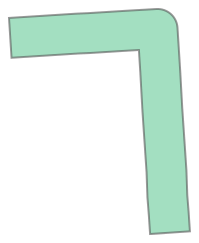

In [152]:
buffer_0

In [147]:
buffer_1 =GeoDataFrame(org_network[org_network.index.isin(str_to_wrk_on['index_right'])].buffer(distance  = 20, cap_style=2))
gpd.overlay(buffer_1, buffer_0, how='intersection')

AttributeError: 'Polygon' object has no attribute 'crs'

,old_index,name_left,highway_left,bearing_left,group_left,is_simplif_left,length_left,geometry,index_right,name_right,highway_right,bearing_right,group_right,is_simplif_right,length_right
205,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",15073,Via Virginia Angiola Borrino,residential,86.8,-1,0,67.462424
276,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",10619,Via Luigi Pasteur,residential,176.2,-1,0,19.195201
277,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",10617,Via Luigi Pasteur,residential,176.2,-1,0,17.219956
278,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",10618,Via Luigi Pasteur,residential,176.2,-1,0,125.374900
279,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",10620,Via Luigi Pasteur,residential,176.2,-1,0,42.819377
280,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",15074,Via Virginia Angiola Borrino,residential,86.8,-1,0,10.773640
281,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",15072,Via Virginia Angiola Borrino,residential,86.8,-1,0,38.101164
282,6916,NaN,NaN,NaN,NaN,NaN,352.536442,"LINESTRING (846757.429 5633375.691, 846807.444...",15071,Via Virginia Angiola Borrino,residential,86.8,-1,0,31.589780


In [ ]:
group[group.index]

In [98]:
df.drop(columns='length_right',inplace=True)
rel_col = [col for col in df.columns if col.endswith("right")] + ['length_left','geometry']
df =df [rel_col]
# Replace '_right' with an empty string for all column names
df.columns = df.columns.str.replace(r'_right$', '', regex=True)
df.columns = df.columns.str.replace(r'_left$', '', regex=True)
df = df.drop(columns='index')
df.index.name = None
df.to_file(f'{data_folder}/delete_2_nodes/no_name_new.shp')

In [46]:
df

,name,highway,bearing,group,is_simplif,length,length,geometry
6802,Great Highway,primary,174.211268,0,1,1481.048301,1629.843466,"LINESTRING (-13636969.933 4548334.470, -136371..."
6803,Sutro Baths Upper Trail,footway,48.266667,-1,0,277.815797,456.738480,"LINESTRING (-13637993.894 4548620.275, -136379..."
6804,Merrie Way,path,167.740000,-1,0,58.764249,247.492278,"LINESTRING (-13637898.738 4548503.808, -136379..."
6805,The Esplanade,footway,174.446875,-1,0,57.775284,58.355067,"LINESTRING (-13637947.396 4547695.747, -136379..."
6806,The Esplanade,footway,174.446875,-1,0,58.028647,65.626158,"LINESTRING (-13637920.802 4547422.783, -136379..."
...,...,...,...,...,...,...,...,...
11728,Dedman Court,residential,53.500000,-1,0,101.643735,415.725378,"LINESTRING (-13623910.598 4542288.799, -136239..."
11729,Hunter's Point Power Plant Trail,"['cycleway', 'footway']",116.200000,-1,0,244.169464,544.191938,"LINESTRING (-13622838.013 4542042.932, -136228..."
11730,Macalla Road,tertiary,113.300000,-1,0,327.679083,910.930142,"LINESTRING (-13621897.853 4552776.615, -136217..."
11731,"['Healy Avenue', 'North Gate Road']",residential,102.100000,-1,0,187.462599,187.462599,"LINESTRING (-13621253.847 4553119.948, -136212..."


In [ ]:

my_network

In [ ]:
def delete_false_intersection(self,name_to_splt='name'):

        if 'length' in self.my_network.columns: # To run the code smoothly we need to remove 'length' col if exist
            self.my_network.drop(columns='length',inplace= True)
        org_network= self.my_network.copy()
        # It should be executed twice in order to clean all
        for _  in range(2):
            # First clean all the false node
            self.my_network = remove_false_nodes(self.my_network)
            # the previous function has changed the topology so the length should be updated
            self.my_network['length'] =self.my_network.length
            self.my_network  =self.my_network.drop_duplicates(subset='length') # remove false intersection duplicate many polyline which should be removed
            self.my_network.reset_index(drop=True,inplace= True) # Changes has been made to the geometry so the index should be reset

        # Update street when it is empty
        def update_street_name():
            """
            The function: remove_false_nodes delete the polyline street names so this method repair that by found for those without name the closet polyline from the original dataframe and use its name.
            :return:
            """
            df1= self.my_network
            # Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
            df3 = df1[df1[name_to_splt].notna()]
            df4 = df1[df1[name_to_splt].isna()]
            df = gpd.sjoin_nearest(df4,org_network)
            # use only one polyline from the original dataframe for name even if the algorithm may found more
            df = df.reset_index().drop_duplicates(subset='index', keep='first').set_index('index',drop=True)
            rel_col = [col for col in df.columns if col.endswith("right")] + ['length','geometry']
            df =df [rel_col]
            # Replace '_right' with an empty string for all column names
            df.columns = df.columns.str.replace(r'_right$', '', regex=True)
            df = df.drop(columns='index')
            df.index.name = None
            self.my_network =  df.append(df3)

        update_street_name()


In [11]:
obj_intersection.delete_false_intersection()

obj_intersection.my_network.to_file(f'{data_folder}/delete_2_nodes/top_0_0.shp')
obj_intersection.intersection_network()
obj_intersection.my_network.to_file(f'{data_folder}/split_tp_intersection/top_0.shp')

100%|██████████| 1543/1543 [00:08<00:00, 178.94it/s]


In [77]:

line_name ='line_name'
if is_junction:

    exist_data= obj_intersection.my_network.reset_index().reset_index(names=line_name)
    my_roundabout=Roundabout(exist_data)
    deadend_lines, deadend_pnts = my_roundabout.deadend()

    # update the current network
    change_geo = my_roundabout.my_spatial_join(deadend_lines, deadend_pnts,line_name)
    my_roundabout.update_the_current_network(change_geo)

    my_roundabout.network.drop_duplicates(subset=line_name,inplace=True)
    # Improve roundabout
    # First buffer around centroid
    centr_name= 'centr_name'
    buffer_around_centroid= my_roundabout.centroid['geometry'].buffer(cap_style=1, distance=30)

    # s_join between buffer to lines (reset index to retain the original centroid name which can apper more than one in the results). always stay with data you need and with understandable name
    roundabout_with_lines =gpd.sjoin(left_df=GeoDataFrame(geometry=buffer_around_centroid,crs=project_crs).reset_index(),right_df=my_roundabout.network[['geometry',line_name]]).drop_duplicates(subset=['index',line_name]).rename(columns={"index":centr_name})[['geometry',line_name,centr_name]]

    # To facilitate the searching process
    my_roundabout.network.set_index(line_name,inplace=True)
    # To facilitate easy access to point centroid geometry data, it is advisable to store the information in an object that provides efficient retrieval.
    pnt_centroid_temp = my_roundabout.centroid['geometry']
    #  Group the data by centroid
    for center_line in roundabout_with_lines.groupby(centr_name):
        #  Iterate over each group after performing a groupby() operation
        for center in center_line[1].itertuples():
            # Find the line that connects to the current centroid and obtain its vertices
            line_to_test = my_roundabout.network.loc[center[2]]
            vertices_line = list(line_to_test['geometry'].coords)
            pnt_test = [vertices_line[0],vertices_line[-1]]
            # To determine if the current line is already connected to the current centroid,.
            is_connected = my_roundabout.centroid[my_roundabout.centroid['geometry'].isin([Point(pnt_test[0]),Point(pnt_test[-1])])]
            if len(is_connected)>0 and center[3] in is_connected['name']:
                continue

            if len(vertices_line)==2:
                vertices_line.insert(1, pnt_centroid_temp[center[3]])
            else:
                my_list = [pnt_centroid_temp[center[3]].distance(Point(temp)) for temp in vertices_line]
                # Find the minimum index
                min_index = min(range(len(my_list)), key=my_list.__getitem__)
                if min_index ==0:
                    vertices_line.insert(0,pnt_centroid_temp[center[3]])
                elif min_index == len(my_list)-1:
                    vertices_line.append(pnt_centroid_temp[center[3]])
                else:
                    vertices_line[min_index] = pnt_centroid_temp[center[3]]
            new_geo = LineString(vertices_line)
            my_roundabout.network.at[center[2],'geometry'] = new_geo
# Extend
    new_network2 = my_roundabout.network.reset_index()
    new_network2.drop(columns='index',inplace=True)
else:
    new_network2=  obj_intersection.my_network.reset_index()

new_network2.to_file(f'{data_folder}/ra_network.shp')


In [78]:
extend_lines_f= extend_lines(new_network2,100)
extend_lines_f['length'] = extend_lines_f.length
extend_lines_f.to_file(f'{data_folder}/extend_network.shp')

obj_intersection_1 = Intersection(extend_lines_f.copy(),1)
obj_intersection_1.delete_false_intersection('str_name')
obj_intersection_1.my_network.to_file(f'{data_folder}/delete_2_nodes/top_20.shp')

In [79]:
obj_intersection_1.intersection_network()

 91%|█████████ | 49758/54734 [00:07<00:00, 6464.56it/s]

6409,11000:GEOMETRYCOLLECTION (LINESTRING (849247.5855611513 5630512.478084865, 849222.2137190597 5630513.776590068), POINT (849247.096878846 5630514.638943701))
11000,6409:GEOMETRYCOLLECTION (LINESTRING (849222.2137190597 5630513.776590068, 849247.5855611513 5630512.478084865), POINT (849247.096878846 5630514.638943701))


100%|██████████| 945/945 [00:04<00:00, 195.26it/s]


In [80]:
# Clear short segments
final2 = EnvEntity(obj_intersection_1.my_network.reset_index())
final2.update_the_current_network(final2.get_deadend_gdf(delete_short=100))
final2.network.to_file(f'{data_folder}/final2.shp')